In [13]:
import jax
#jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev, value_and_grad
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results
from jax_filters import apply_filtering_fixed_linear, kalman_filter_process, filter_step_linear
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix

key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
num_steps = 1000 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples

def create_stable_matrix(n, key): # Generate a symmetric random matrix
    A = random.normal(key, (n, n))
    A = (A + A.T) / 2
    eigenvalues, eigenvectors = eigh(A)
    scaled_eigenvalues = eigenvalues / (jnp.abs(eigenvalues).max() + 0.1)  # Scale eigenvalues to ensure stability (spectral radius < 1)
    A_stable = eigenvectors @ jnp.diag(scaled_eigenvalues) @ eigenvectors.T
    return A_stable

# Model parameters
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
q = random.normal(key, (n, n))/5
Q = q@q.T + jnp.eye(n)*0.1  # Process noise covariance matrix (Sigma in Julia code)
#H = jnp.eye(n)[::2] #partial observation
H = jnp.eye(n)
m0 = jnp.ones((n,))
R = jnp.eye(H.shape[0])  # R now becomes 20x20 for partial H 20*40
inv_R = inv(R)
M = create_stable_matrix(n,key)    # State transition matrix (A)
observation_interval = 1

# State initialization
vd0 = m0 + random.multivariate_normal(key, jnp.zeros(n), C0)
key, _ = random.split(key)

def state_transition_function(x):
    return jnp.dot(M, x)

def jacobian_function(x):
    return M

jac_func = Partial(jacobian_function)
A_step = Partial(state_transition_function)

In [14]:
observations, true_states = generate_true_states(key, num_steps, n, vd0, H, Q, R, A_step, observation_interval)

In [15]:
@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, M, H, Q, R, y, key, N, num_steps, J0):
    m_preds, C_preds, m_updates, C_updates = apply_filtering_fixed_linear(m0, C0, y, K, n, M, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(m_preds, C_preds, m_updates, C_updates, n, A_step, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, m_updates, C_updates), y, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    return cost


In [16]:
@partial(jit, static_argnums=(3))
def var_cost_single_step(K, m0, C0, n, Q, H, R, y_curr, key, J, J0):
    (m_update, C_update), _  = filter_step_linear((m0, C0), y_curr, K, n, M, H, Q, R)
    log_likelihood_val = log_likelihood(m_update[jnp.newaxis, :], y_curr[jnp.newaxis, :], H, R, J=1, J0=J0)
    # Calculate the KL divergence between the predicted and updated state distributions
    m_pred = state_transition_function(m0)
    C_pred = M @ C0 @ M.T + Q
    kl_divergence = KL_gaussian(n, m_update, C_update, m_pred, C_pred)
    # Combine the KL divergence and the negative log-likelihood to form the cost
    cost = kl_divergence - log_likelihood_val
    return cost

In [17]:
P = solve_discrete_are(M.T, H.T, Q, R)
# Compute steady-state Kalman gain K
K_steady = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)

In [18]:
base_m, base_C, base_K  = kalman_filter_process(A_step, jac_func, m0, C0, observations, H, Q, R)

In [37]:
true_div1 = []
prediction_errors1 = [] 
norms1 = []
Ks1 = []

online = True

# Define the gradient of the cost function
var_cost_single_grad = value_and_grad(var_cost_single_step, argnums = 0)

# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.1
alpha = 1e-5

for i in tqdm(range(num_steps)):
    key, _ = random.split(key)
    y_curr = observations[i] 
    # Update the gradient and Kalman gain
    for j in range(100):
        grad_K = var_cost_single_grad(K_opt, m0, C0, n, Q, H, R, y_curr, key, num_steps, J0)
        K_opt -= alpha * grad_K
    Ks1.append(K_opt)
    norms1.append(jnp.linalg.norm(K_opt - K_steady)) 
    (m_update, C_update), _ = filter_step_linear((m0, C0), y_curr, K_opt, n, M, H, Q, R)
    prediction_error = jnp.square(m_update - true_states[i]).mean()  # Assuming true_states[i] is available
    prediction_errors1.append(prediction_error)
    true_div1.append(KL_gaussian(n, m_update, C_update, base_m[i], base_C[i]))
    # Prepare for the next step
    m0, C0 = m_update, C_update

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
import os
from jax_vi import plot_optimization_results, plot_k_matrices

subfolder_name = 'linear_results'
os.makedirs(subfolder_name, exist_ok=True)  # Create directory if it doesn't exist
file_base_name = "linear_gain"

if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)

plot_optimization_results(norms1, prediction_errors1, true_div1, n_iters, file_path)

file_base_name = "linear_gain_matrices"
if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)
plot_k_matrices(K_steady, K_opt, file_path)


NameError: name 'n_iters' is not defined

In [ ]:
last_200_errors_online = jnp.array(prediction_errors1[-200:])
print("Mean error for last 200 timesteps (online)", jnp.mean(last_200_errors_online)

In [19]:
K_opt = jnp.eye(n) * 0.4


true_div = []
prediction_errors = [] 
norms = []
last_200_errors = []    # Errors for the last 200 timesteps
Ks = []
online = False


t = 0  
n_iters = 100
var_cost_grad = value_and_grad(var_cost, argnums=0)
# Initial guess for K and optimization parameters
key, _ = random.split(key)
alpha = 1e-5

for i in tqdm(range(n_iters)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    cost_grad, grad_K = var_cost_grad(K_opt, m0, C0, n, M, H, Q, R, observations, key, N, num_steps, J0)
    K_opt -= alpha * grad_K
    Ks.append(K_opt)
    # Apply filtering with the newly optimized K to generate state predictions
    _, _, predicted_states, covariances = apply_filtering_fixed_linear(m0, C0, observations, K_opt, n, M, H, Q, R)
    prediction_error = jnp.mean(jnp.mean((predicted_states - true_states)**2, axis=1))#jnpl.norm(predicted_states - true_states) ** 2 / len(true_states)
    prediction_errors.append(prediction_error)
    last_200_prediction_error = jnp.mean((predicted_states[-200:] - true_states[-200:])**2)
    last_200_errors.append(last_200_prediction_error)
    norms.append(norm(K_opt - K_steady))
    print(last_200_prediction_error)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    
    true_div.append(total_kl_divergence / num_steps)
    print(total_kl_divergence / num_steps)

  0%|          | 0/100 [00:00<?, ?it/s]

0.7707723
9.966943
0.71108747
7.452211
0.67156655
5.8200073
0.64303064
4.662216
0.6217338
3.804559
0.6050744
3.1470187
0.59212244
2.6386402
0.5816994
2.2286332
0.57310504
1.8938442
0.56614566
1.6210215
0.5603244
1.3960074
0.55541724
1.2056897
0.55134684
1.0485163
0.54784656
0.91468865
0.5449089
0.8004302
0.54243165
0.703691
0.5402333
0.61942905
0.53841376
0.5474184
0.5367507
0.48524415
0.53537196
0.43141463
0.534221
0.3842554
0.5332244
0.34345588
0.5323
0.3078986
0.531553
0.27643308
0.53088576
0.24953723
0.5302674
0.22509849
0.5297935
0.20453657
0.52930534
0.18618116
0.5288746
0.17008507
0.5284972
0.1551523
0.5281345
0.1423868
0.5278574
0.13129067
0.5276603
0.12138187
0.5274186
0.11228765
0.52714103
0.10431609
0.5269234
0.09769781
0.52678794
0.09135045
0.5266609
0.08597083
0.5264948
0.080890834
0.52637655
0.076563604
0.5262225
0.072685614
0.526127
0.0691233
0.5260536
0.06567595
0.52599984
0.06292803
0.5259188
0.060629316
0.5258358
0.058507085
0.5258107
0.0563203
0.5257492
0.05475803
0.

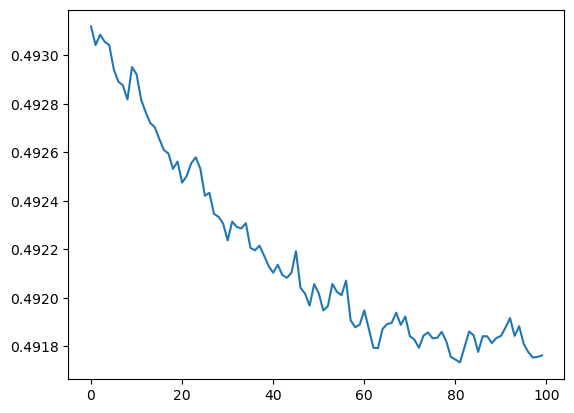

In [39]:
#plt.plot(norms[-50:])
plt.plot(last_200_errors)

In [ ]:
#print("Mean error for last 200 timesteps (offline)", jnp.mean(jnp.array(last_200_errors[-10:])))
classic_kf_prediction_errors = jnp.mean(jnp.square(base_m - true_states), axis=1)

print("Classic KF Prediction MSE (last 200 steps):", jnp.mean(classic_kf_prediction_errors[-200:]))

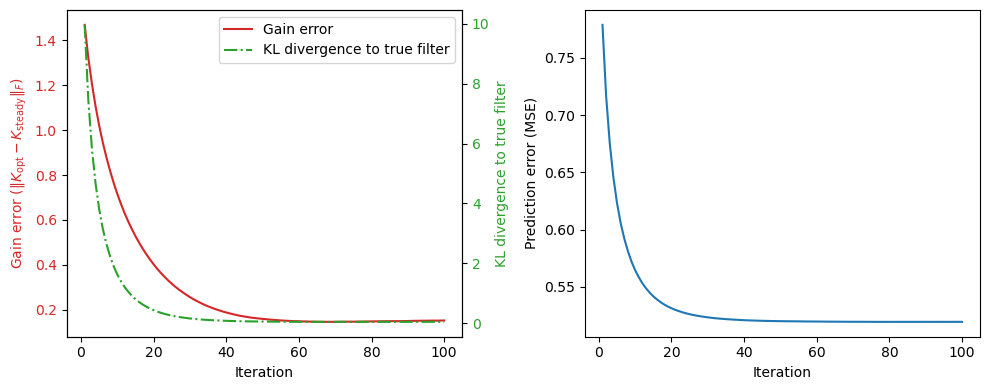

In [20]:
import os
from jax_vi import plot_optimization_results, plot_k_matrices

subfolder_name = 'linear_results'
os.makedirs(subfolder_name, exist_ok=True)  # Create directory if it doesn't exist
file_base_name = "linear_gain"

if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)

plot_optimization_results(norms, prediction_errors, true_div, n_iters, file_path)




In [23]:
true_div[-1]

Array(0.04297115, dtype=float32)

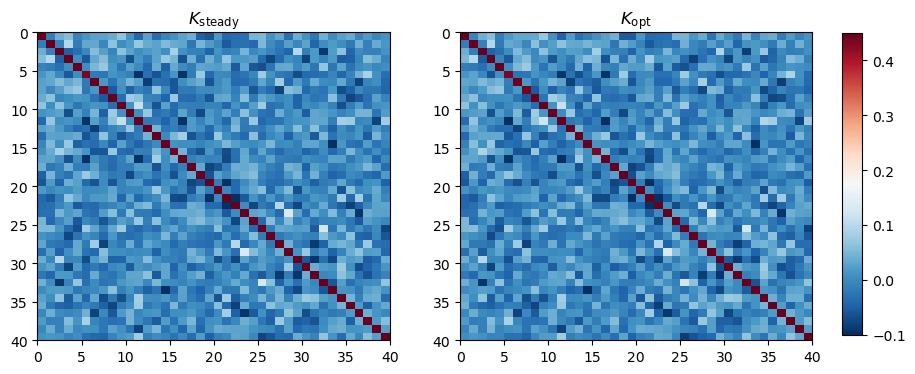

In [10]:
file_base_name = "linear_gain_matrices"
if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)
plot_k_matrices(K_steady, K_opt, file_path)